# Imports

In [1]:
from pipeline import loading_pipeline
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import KBinsDiscretizer

from model_training import PyTorchModel, evaluate_regression_model, evaluate_classification_model, display_results
import transformers

# Preprocessing

In [2]:
X_train, y_train, X_test, y_test = loading_pipeline()

Number of samples: 8600
Signal Length: 2816
X-Shape: (8100, 1408, 2)
y-Shape: (8100,)
X-Shape: (500, 1408, 2)
y-Shape: (500,)
Augmented X.shape: (40500, 1152, 2)
Augmented y.shape: (40500,)
Trimmed X.shape: (500, 1152, 2)


# Transformer

In [3]:
num_classes = len(np.unique(y_train))
print(num_classes)

5


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# # Quantization
# num_bins = 75  # Adjust as needed
# kbin = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
# kbin.fit(X_train.reshape(-1, 1))
# 
# X_train_quantized = kbin.transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], -1)
# X_test_quantised = kbin.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], -1)

Using device: cuda:0


In [5]:
class AttentionPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_model))

    def forward(self, x):
        attn_weights = F.softmax(torch.matmul(x, self.query), dim=1)
        pooled = torch.matmul(attn_weights.unsqueeze(1), x).squeeze(1)
        return pooled, attn_weights

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_classes, num_layers, seq_len):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attention_pool = AttentionPool(d_model)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        # Project input features to d_model dimensions and apply positional encoding
        src = self.input_projection(src) * torch.sqrt(torch.tensor(self.d_model, dtype=src.dtype))
        src += self.positional_encoding[:, :src.size(1), :]
        src = src.permute(1, 0, 2)  # [seq_len, batch_size, features]
        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output.permute(1, 0, 2)  # [batch_size, seq_len, features]
        pooled, _ = self.attention_pool(transformer_output)
        output = self.fc(pooled)
        return output

In [6]:
# Initialize the model with the correct input dimensions
input_dim = X_train.shape[2]  # Number of features per timestep in the signal
seq_len = X_train.shape[1]  # Sequence length
d_model = 128  # Size of the feature space to project the inputs
nhead = 4  # Number of attention heads
num_layers = 2  # Number of transformer layers
transformer_model = TransformerModel(input_dim, d_model, nhead, num_classes, num_layers, seq_len)


# Assuming you have defined 'device' (e.g., torch.device("cuda:0"))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

# Wrap the model in the PyTorchModel class
model = PyTorchModel(transformer_model, criterion, optimizer, device)

/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
results = evaluate_classification_model(model, X_train, y_train, X_train, y_train, X_test, y_test)

Epoch [1/25], Train Loss: 1.5940, Val Loss: 1.5742
Epoch [2/25], Train Loss: 1.5779, Val Loss: 1.5782
Epoch [3/25], Train Loss: 1.5712, Val Loss: 1.5602
Epoch [4/25], Train Loss: 1.5670, Val Loss: 1.5624
Epoch [5/25], Train Loss: 1.5656, Val Loss: 1.5595
Epoch [6/25], Train Loss: 1.5636, Val Loss: 1.5593
Epoch [7/25], Train Loss: 1.5580, Val Loss: 1.5573
Epoch [8/25], Train Loss: 1.5594, Val Loss: 1.5624
Epoch [9/25], Train Loss: 1.5619, Val Loss: 1.5593
Epoch [10/25], Train Loss: 1.5564, Val Loss: 1.5505
Epoch [11/25], Train Loss: 1.5478, Val Loss: 1.5597
Epoch [12/25], Train Loss: 1.5462, Val Loss: 1.5570
Epoch [13/25], Train Loss: 1.5455, Val Loss: 1.5507
Epoch [14/25], Train Loss: 1.5438, Val Loss: 1.5608
Epoch [15/25], Train Loss: 1.5413, Val Loss: 1.5685
Early stopping triggered
Epoch [1/25], Train Loss: 1.5921, Val Loss: 1.5787
Epoch [2/25], Train Loss: 1.5718, Val Loss: 1.5739
Epoch [3/25], Train Loss: 1.5692, Val Loss: 1.5660
Epoch [4/25], Train Loss: 1.5677, Val Loss: 1.6208


Performance Metrics Table:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
T0 vs T1 vs T2 vs T3 vs T4,0.234,0.191763,0.234,0.169064,NaN
"T0 vs (T1, T2, T3, T4)",0.800,0.640000,0.800,0.711111,0.500
T0 vs T1,0.450,0.307988,0.450,0.325236,0.450
T0 vs T2,0.490,0.455674,0.490,0.367560,0.490
T0 vs T3,0.640,0.651910,0.640,0.632803,0.640
T0 vs T4,0.705,0.716450,0.705,0.701046,0.705


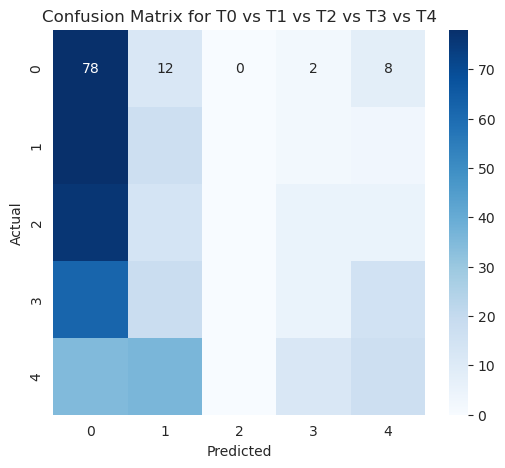

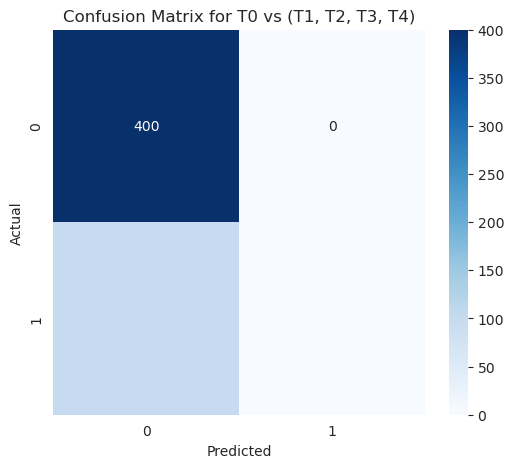

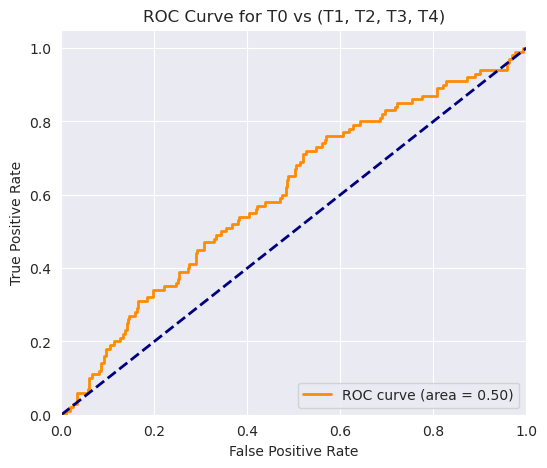

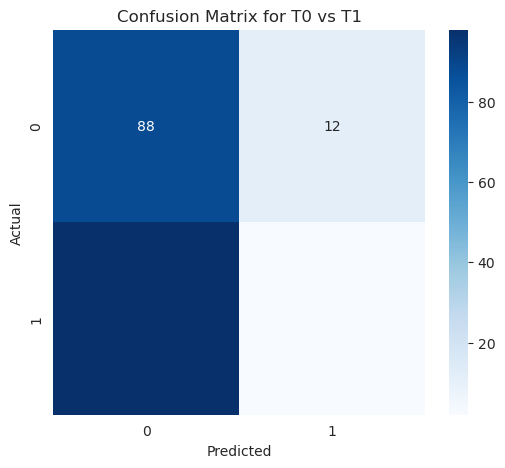

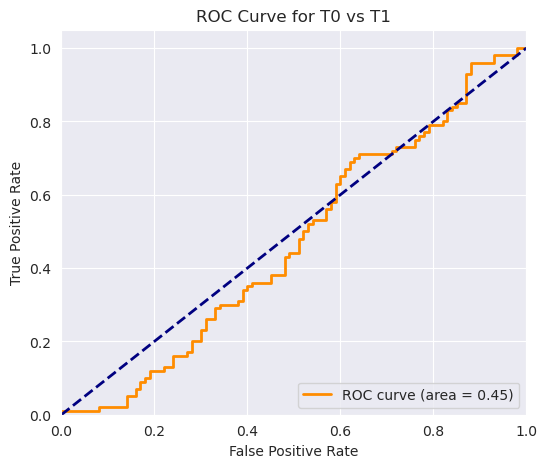

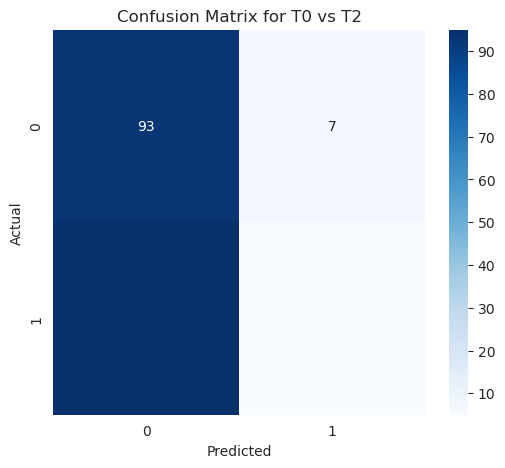

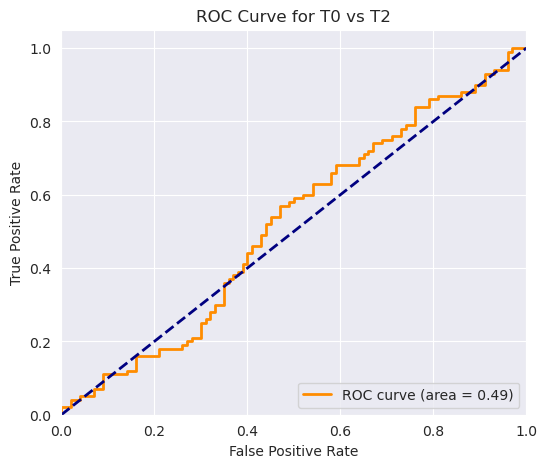

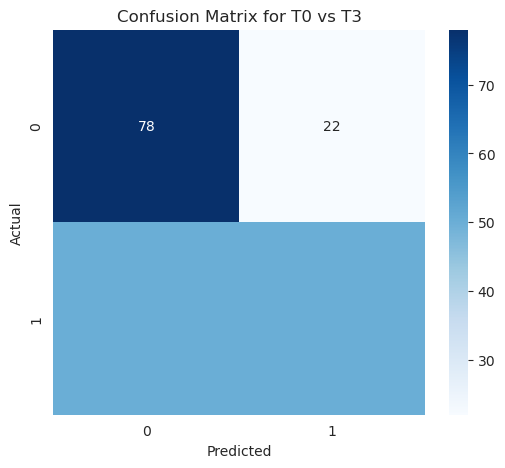

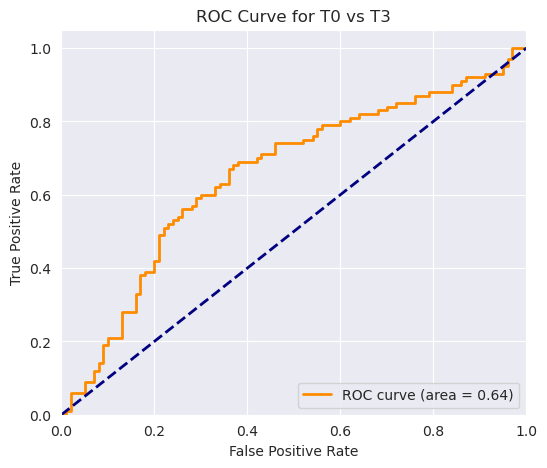

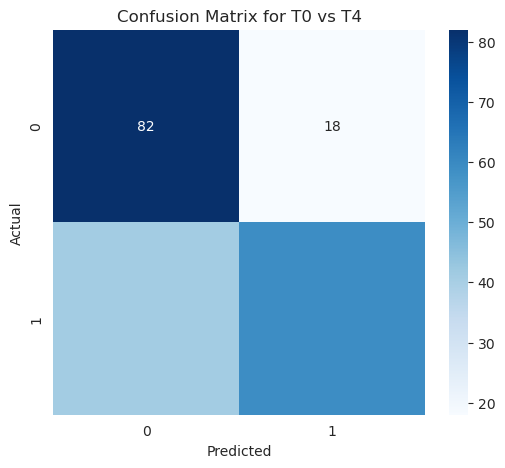

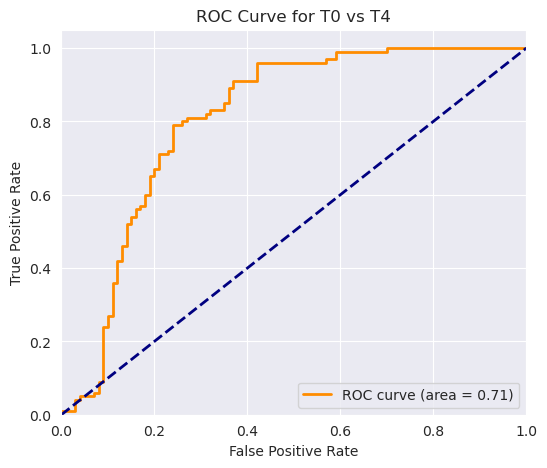

In [8]:
display_results(results)

In [9]:
#todo class balancing for T0 vs (T1, t2, t3, t4)